# Using PyTorch with Amazon SageMaker's training and hosting services

1. [Introduction](#Introduction)
2. [Setup](#Setup)
3. [Train the model](#Train-the-model)
4. [Host the model](#Host-the-model)
5. [Test the model](#Test-the-model)
6. [Clean up](#Clean-up)

## Introduction

The previous lab performed training and prediction directly in the Jupyter notebook environment. With this lab, we transition to leveraging SageMaker's managed training and hosting services. To accomplish this, we use [Amazon SageMaker's PyTorch container](https://sagemaker.readthedocs.io/en/stable/using_pytorch.html), which lets you provide your training code as a Python script. The container also provides a flexible way for you to customize how inference inputs and outputs are handled over a REST interface. 

## Setup

Before preparing the data, there are some initial steps required for setup. To train the image classification algorithm on Amazon SageMaker, we need to setup and authenticate the use of AWS services. To begin with, we need an AWS account role with SageMaker access. Here we will use the execution role the current notebook instance was given when it was created.  This role has necessary permissions, including access to your data in S3.

In [5]:
#!pip install sagemaker # workaround for Studio preview issue

In [4]:
import sagemaker
from sagemaker import get_execution_role

role = get_execution_role()
print(role)
sess = sagemaker.Session()

arn:aws:iam::355151823911:role/service-role/AmazonSageMaker-ExecutionRole-20180515T132694


We also need to identify the S3 bucket that you want to use for providing training and validation datasets.  It will  be used to store the tranied model artifacts as well. In this notebook, we use a default bucket for use with SageMaker in your account. Alternatively, you could use whatever bucket you would like.  We use an object prefix to help organize the bucket content.

In [6]:
bucket = sess.default_bucket() # or use your own custom bucket name
prefix = 'DEMO-PYT-image-classification-birds'

## Data Preparation

This notebook assumes you have already downloaded and unpacked the dataset into your notebook instance as part of the first lab.

## Set some parameters for the rest of the notebook to use

Here we define a few parameters that help drive the rest of the notebook.  For example, `SAMPLE_ONLY` is defaulted to `True`. This will force the notebook to train on only a handful of species.  Setting `SAMPLE_ONLY` to false will make the notebook work with the entire dataset of 200 bird species.  This makes the training a more difficult challenge, and you will need to tune parameters and run more epochs.

An `EXCLUDE_IMAGE_LIST` is defined as a mechanism to address any corrupt images from the dataset and ensure they do not disrupt the process.

In [9]:
import pandas as pd
import boto3
import json
import pandas as pd

runtime = boto3.client(service_name='runtime.sagemaker')

import matplotlib.pyplot as plt
%matplotlib inline

# To speed up training and experimenting, you can use a small handful of species.
# To see the full list of the classes available, look at the content of CLASSES_FILE.
SAMPLE_ONLY  = True
CLASSES = [13, 17, 35, 36]#, 47, 68, 73, 75, 87, 95, 120, 179, 192]
#CLASSES = [ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10,  11,  12,  13,
#           17, 35, 36, 47, 68, 73, 75, 87, 95, 120, 179, 192, 193]

# Otherwise, you can use the full set of species
if not SAMPLE_ONLY:
    CLASSES = []
    for c in range(200):
        CLASSES += [c + 1]
    prefix = prefix + '-full'

#BASE_DIR   = 'CUB_200_2011/'
BASE_DIR   = 'CUB_MINI/'

IMAGES_DIR = BASE_DIR + 'images/'
CLASSES_FILE = BASE_DIR + 'classes.txt'

EXCLUDE_IMAGE_LIST = ['087.Mallard/Mallard_0130_76836.jpg']

SPLIT_RATIOS = (0.6, 0.2, 0.2)

CLASS_COLS   = ['class_number','class_id']

JOB_PREFIX   = 'pyt-ic'

Show the list of bird species or dataset classes the model will be trained to predict. You will use this in the next notebook as well (3 - Batch).

In [10]:
classes_df = pd.read_csv(CLASSES_FILE, sep=' ', names=CLASS_COLS, header=None)
criteria = classes_df['class_number'].isin(CLASSES)
classes_df = classes_df[criteria]

class_name_list = sorted(classes_df['class_id'].unique().tolist())
print(class_name_list)

['013.Bobolink', '017.Cardinal', '035.Purple_Finch', '036.Northern_Flicker']


## Create train/val/test dataframes from our dataset

In this lab, we've moved the train/test split logic to a utilities script to keep the focus of the notebook on the actual training and hosting steps.

In [11]:
from utils import split
train_df, val_df, test_df = split.get_train_val_dataframes(BASE_DIR, CLASSES, EXCLUDE_IMAGE_LIST, SPLIT_RATIOS)

Using 237 images from 4 classes
num images total: 11788

num train: 142
num val: 47
num test: 48


## Prepare the data channels for Amazon SageMaker
When using Amazon SageMaker's managed training service, you need to provide the datasets to the training algorithm. This is primarily handled via populating S3 buckets, and by indicating the location of data channels such as train, test, and validation. You also need to consider the data format. In our case, to keep things simple, we will populate the data channels with folders containing the original JPG images organized by class folders.

In [12]:
CHANNEL_FOLDER = 'data'

### Populate local data channels
Here we populate the local channel folders, and we handle re-populating in case we have already run through this notebook with a different subset of bird species. The local content will be synchronized to our s3 bucket for access by the SageMaker training service. Note that if you are running this notebook with a large number of bird species, this step could take several minutes. You can skip these cells if you are re-running this notebook after already having populated these folders. 

In [13]:
import os
cwd = os.getcwd()

In [14]:
def copy_files_for_channel(df, channel_name, verbose=False):
    print('\nCopying files for {} images in channel: {}...'.format(df.shape[0], channel_name))
    for i in range(df.shape[0]):
        target_fname = df.iloc[i]['image_file_name']
        if verbose:
            print(target_fname)
        !cp $cwd/$IMAGES_DIR/$target_fname $cwd/$CHANNEL_FOLDER/$channel_name/$target_fname

In [15]:
if os.path.exists(CHANNEL_FOLDER):
    print('About to remove {}/{}'.format(cwd, CHANNEL_FOLDER))
    perform_delete = input('Are you sure you want to remove it and start fresh (yes/no)?')
    if perform_delete == 'yes':
        for ch in ['train', 'test', 'validation']:
            !rm -i -rf $CHANNEL_FOLDER/$ch/*
            !rm -i -rf $CHANNEL_FOLDER/$ch
            !mkdir  $CHANNEL_FOLDER/$ch

        for c in class_name_list:
            !mkdir $CHANNEL_FOLDER/train/$c
            !mkdir $CHANNEL_FOLDER/validation/$c
            !mkdir $CHANNEL_FOLDER/test/$c
            
        copy_files_for_channel(val_df,   'validation')
        copy_files_for_channel(test_df,  'test')
        copy_files_for_channel(train_df, 'train')
else:
    print('Channel folder does not yet exist. Creating it and subfolders for each channel.')
    os.mkdir(CHANNEL_FOLDER)
    os.mkdir(CHANNEL_FOLDER + '/validation')
    os.mkdir(CHANNEL_FOLDER + '/test')
    os.mkdir(CHANNEL_FOLDER + '/train')
    for c in class_name_list:
        os.mkdir('{}/{}/{}'.format(CHANNEL_FOLDER, 'validation', c))
        os.mkdir('{}/{}/{}'.format(CHANNEL_FOLDER, 'test', c))
        os.mkdir('{}/{}/{}'.format(CHANNEL_FOLDER, 'train', c))
    
    copy_files_for_channel(val_df,   'validation')
    copy_files_for_channel(test_df,  'test')
    copy_files_for_channel(train_df, 'train')

Channel folder does not yet exist. Creating it and subfolders for each channel.

Copying files for 47 images in channel: validation...

Copying files for 48 images in channel: test...

Copying files for 142 images in channel: train...


### Upload content of each data channel to S3
Note that for local mode training, this copy to s3 is not necessary. SageMaker local mode is helpful for early iterations of the development of a new model. Once the approach is more stable, you typically then use SageMaker training jobs on larger sets of data and with additional epochs.

In [18]:
print('About to uploaded your image data to s3://{}/{}'.format(bucket, prefix))
print('This will ensure you have the latest data for training, but it takes a while if using the full 200 classes.')
if input('Are you sure you want to replace your s3 images?') == 'yes':
    print('Clearing out s3://{}/{}/'.format(bucket, prefix))
    for ch in ['train', 'test', 'validation']:
        !aws s3 rm --quiet --recursive s3://$bucket/$prefix/$ch/
    print('\nSynchronizing local data channels with s3...')
    !aws s3 sync $CHANNEL_FOLDER s3://$bucket/$prefix/

print('contents of s3://{}/{}/'.format(bucket, prefix))
!aws s3 ls s3://$bucket/$prefix/

About to uploaded your image data to s3://sagemaker-us-east-2-355151823911/DEMO-PYT-image-classification-birds
This will ensure you have the latest data for training, but it takes a while if using the full 200 classes.


Are you sure you want to replace your s3 images? no


contents of s3://sagemaker-us-east-2-355151823911/DEMO-PYT-image-classification-birds/
                           PRE test/
                           PRE train/
                           PRE validation/


## Train the model <a class="anchor" id="Train-the-model"></a>
When using SageMaker's TensorFlow container, the custom PyTorch training code is provided via a Python script in a separate file that gets passed to SageMaker. For our example, that script is shown below for completeness in the notebook. Study that code before proceeding to the actual training. Pay attention to any differences from the code you used in the first lab when training directly in the notebook:

- Use of script parameters to make the code more flexible. We will take advantage of these parameters later on when doing automatic model tuning.
- Use of PyTorch ImageFolder to provide datasets directly on top of the folders that SageMaker establishes for each input channel.
- Different approach to model saving to be compatible with SageMaker's use of TensorFlow Serving.

In [19]:
!pygmentize 'code/train-resnet.py'

# Copyright 2018 Amazon.com, Inc. or its affiliates. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License"). You
# may not use this file except in compliance with the License. A copy of
# the License is located at
#
#     http://aws.amazon.com/apache2.0/
#
# or in the "license" file accompanying this file. This file is
# distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF
# ANY KIND, either express or implied. See the License for the specific
# language governing permissions and limitations under the License.

import numpy as np
from numpy import argmax
import os
import io
import json
import argparse
import glob
import time
from PIL import Image

import torch
import torch.distributed as dist
from torch.autograd import Variable
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torch.utils.data.sampler import RandomSampler
import torch.utils.data.distribu

To train in local mode, it is necessary to have Docker Compose or NVIDIA-Docker-Compose (for GPU) installed in the notebook instance.  This simple setup script is required.

In [20]:
!/bin/bash ./setup.sh

/bin/bash: ./setup.sh: No such file or directory


### Create the SageMaker training job using the PyTorch container
Here we establish the PyTorch estimator object. Note that this notebook code is designed to support SageMaker remote training jobs as well as local mode training. Set `local = False` to use SageMaker's training service on separate managed training instances. Metric definitions are provided so that you can visualize metrics from the SageMaker console as well as from CloudWatch. These same metrics can be used when optimizing your model with automatic model tuning.

For this lab, run the whole notebook with `local = True` first. Once you have understood all that is going on, and have seen it work successfully, change to `local = False` and re-run the rest of the notebook.

### A note about instance types and account limits
You may find yourself running into an error like this:

````
ResourceLimitExceeded: An error occurred (ResourceLimitExceeded) when calling the CreateTrainingJob operation: The account-level service limit 'ml.p3.8xlarge for training job usage' is 0 Instances, with current utilization of 0 Instances and a request delta of 1 Instances. Please contact AWS support to request an increase for this limit.
````
To avoid customers getting unexpected bills for more powerful and more expensive instance usage, accounts are established by default with limited access to certain instance types. These are soft limits that can be raised by contacting AWS support. This lab defaults to a powerful GPU instance type, but you can run it on a lower-powered instance type. In such a case, you will pay less, but your training jobs will take longer.

In [21]:
import sagemaker
from sagemaker.pytorch import PyTorch
import logging

FRAMEWORK_VERSION = '1.3.1'

local = False
if (local):
    train_instance_type  = 'local'
    train_instance_count = 1
    serve_instance_type  = 'local'
else:
    train_instance_type  = 'ml.p3.2xlarge' 
    train_instance_count = 1
    serve_instance_type  = 'ml.c5.4xlarge' #p3.2xlarge'

In [22]:
hyperparameters = {'initial_epochs': 25 if SAMPLE_ONLY else 100, 
                   'dropout' : 0.5,
                   'data_dir': '/opt/ml/input/data',
                   'backend' : 'gloo' # for cpu training, use: 'tcp' or 'gloo'; for gpu, use: 'gloo' or 'nccl'
                  }

metric_definitions=[{'Name' : 'validation:acc', 
                     'Regex': '.*Test accuracy: (.*$)'},
                    {'Name' : 'validation:loss', 
                     'Regex': '.*Test loss: (.*).. Test ac.*'},
                    {'Name' : 'train:loss', 
                     'Regex': '.*Train loss: (.*).. Test lo.*'}]

estimator = PyTorch(entry_point='train-resnet.py',
                       source_dir='code',
                       train_instance_type=train_instance_type,
                       train_instance_count=train_instance_count,
                       hyperparameters=hyperparameters,
                       metric_definitions=metric_definitions,
                       role=sagemaker.get_execution_role(),
                       framework_version=FRAMEWORK_VERSION, 
                       debugger_hook_config=False,  # https://tt.amazon.com/0305452782, https://answers.amazon.com/questions/93236
                       py_version='py3',
                       base_job_name=JOB_PREFIX)

## To use Spot instances for SageMaker training, add this set of parameters to your
## call above when creating the TensorFlow estimator object:
##
######    train_use_spot_instances=True, train_max_run=2*60*60, train_max_wait=3*60*60,

Here we establish pointers to where each data channel is located. For local mode training, these will be in the local file system. For remote training, the s3 data channel copies are provided.

In [23]:
data_dir = os.path.join(os.getcwd(), 'data')
print('Local data dir: {}'.format(data_dir))

if (local):
    train_in = f'file://{data_dir}/train'
    test_in  = f'file://{data_dir}/test'
    val_in   = f'file://{data_dir}/validation'
else:
    s3_base = 's3://{}/{}'.format(bucket, prefix)
    train_in = f'{s3_base}/train'
    test_in  = f'{s3_base}/test'
    val_in   = f'{s3_base}/validation'

inputs = {'train':train_in, 'test': test_in, 'validation': val_in}

print(inputs)

Local data dir: /root/sagemaker-workshop/pytorch-workshop/data
{'train': 's3://sagemaker-us-east-2-355151823911/DEMO-PYT-image-classification-birds/train', 'test': 's3://sagemaker-us-east-2-355151823911/DEMO-PYT-image-classification-birds/test', 'validation': 's3://sagemaker-us-east-2-355151823911/DEMO-PYT-image-classification-birds/validation'}


Here we tell the estimator to fit the model. For local mode, this training is performed in the current notebook instance. For remote training, new instances are launched and training is performed on those separate instances. No matter which technique you use, the training script can count on the same interface (script parameters, specific SageMaker environment variables, consistent location of data channels in `/opt/ml/input/data`, and saving to `/opt/ml/model`).

In [24]:
estimator.fit(inputs) 

2020-03-02 17:28:52 Starting - Starting the training job...
2020-03-02 17:28:53 Starting - Launching requested ML instances...
2020-03-02 17:29:51 Starting - Preparing the instances for training.........
2020-03-02 17:31:20 Downloading - Downloading input data
2020-03-02 17:31:20 Training - Downloading the training image.........
2020-03-02 17:32:47 Training - Training image download completed. Training in progress..bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2020-03-02 17:32:48,640 sagemaker-containers INFO     Imported framework sagemaker_pytorch_container.training
2020-03-02 17:32:48,665 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2020-03-02 17:32:48,666 sagemaker_pytorch_container.training INFO     Invoking user training script.
2020-03-02 17:32:48,931 sagemaker-containers INFO     Module default_user_module_name does not provide a setup.py. 
Generating setup.py
2020-03-0

In [25]:
training_job_name = estimator.latest_training_job.name
print(f'Completed training job: {training_job_name}')

Completed training job: pyt-ic-2020-03-02-17-28-52-529


## Host the model

Once the fit method is complete, we can simply call deploy (`estimator.deploy(...)`) to publish the trained model. 

In [26]:
predictor = estimator.deploy(initial_instance_count=1, 
                             instance_type=serve_instance_type)

-----------!

## Test the model

In [27]:
# If using an endpoint that was already in service, you can establish a predictor object using the following code.
#
#from sagemaker import RealTimePredictor
#predictor = RealTimePredictor(endpoint='tensorflow-inference-2020-02-14-12-36-15-896') #<put-endpoint-name-here>')

### Predicting using the SageMaker PyTorch endpoint
When calling your image classifier hosted in a SageMaker endpoint, the call to the predictor is slightly different than what you used in the first lab:

1. In lab 1, we preprocessed the image bytes, which is specific to our base ResNet model. Instead, here we pass the image bytes directly. This hides the implementation detail of a model-specific preprocessing of the image as part of the endpoint. This gives us flexibility to switch to a different implementation down the road (e.g., MobileNetV2, InceptionV3, ...).
2. We indicate the content type for the REST call, in this case `application/x-image`.
3. The results come back as a list of probabilities, one for each possible class.

The rest of the code remains the same.

In [31]:
from PIL import Image
import io, time
import numpy as np
from sagemaker.predictor import json_serializer, json_deserializer

def predict_bird_from_file(fn, verbose=True):
    pil_img = Image.open(fn)
    buf = io.BytesIO()
    pil_img.save(buf, format='JPEG')
    byte_im = buf.getvalue()

    start_time = time.time()
    
    predictor.content_type = 'application/x-image'
    predictor.serializer   = None
    predictor.deserializer = json_deserializer
    
    result = predictor.predict(byte_im)
    
    if verbose:
        print('...took {:.2f} seconds'.format(time.time() - start_time))
        predicted_class_idx = np.argmax(result)
        predicted_class = class_name_list[predicted_class_idx]
        confidence = result[predicted_class_idx]
        display(Image.open(fn).resize((224, 224)))
        print(f'Class: {predicted_class}, confidence: {confidence:.2f}')
    del pil_img
    return result

...took 0.16 seconds


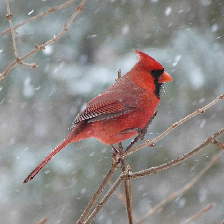

Class: 017.Cardinal, confidence: 0.89


[0.008297104388475418,
 0.8916934728622437,
 0.08866697549819946,
 0.011342387646436691]

In [32]:
predict_bird_from_file('northern-cardinal-1.jpg')

In [33]:
import matplotlib.pyplot as plt
import numpy as np
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.GnBu):
    plt.figure(figsize=(7,7))
    plt.grid(False)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), 
                                  range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.gca().set_xticklabels(class_name_list)
    plt.gca().set_yticklabels(class_name_list)
    plt.gca().set_ylim(len(class_name_list)-0.5, -0.5) # workaround for matplotlib bug 3.1.1
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [34]:
from sklearn.metrics import confusion_matrix
def create_and_plot_confusion_matrix(actual, predicted):
    cnf_matrix = confusion_matrix(actual, np.asarray(predicted),labels=range(len(class_name_list)))
    plot_confusion_matrix(cnf_matrix, classes=range(len(class_name_list)))

### Assess prediction performance against validation and test datasets

In [36]:
# Iterate through entire dataframe, tracking predictions and accuracy. For mistakes, show the image, 
# and the predicted and actual classes to help understand
# where the model may need additional tuning.

def test_image_df(df, verbose=True):
    print('Testing {} images'.format(df.shape[0]))
    num_errors = 0
    preds = []
    acts  = []
    for i in range(df.shape[0]):
        fname = df.iloc[i]['image_file_name']
        act   = int(df.iloc[i]['class_id']) - 1
        acts.append(act)
        prediction_list = predict_bird_from_file(IMAGES_DIR + '/' + fname, verbose=False)
        pred = np.argmax(prediction_list)
        conf = prediction_list[pred]
        preds.append(pred)
        if (pred != act):
            num_errors += 1
            print('ERROR on image index {} -- Pred: {} {:.2f}, Actual: {}'.format(i, 
                                                                   class_name_list[pred], conf, 
                                                                   class_name_list[act]))
            if verbose:
                print(f'    {prediction_list}')
                display(Image.open(IMAGES_DIR + '/' + fname))
    return num_errors, preds, acts

In [37]:
import time

def hit_endpoint_with_load(rough_num_predictions):
    num_val_images = val_df.shape[0]
    times_through_dataset = round(rough_num_predictions / num_val_images)
    print(f'running through val dataset {times_through_dataset} times...\n')
    start_time = time.time()
    for i in range(times_through_dataset):
        num_errors, preds, acts = test_image_df(val_df, verbose=False)
        print('\nAccuracy: {:.2f}, {}/{}\n'.format(1 - (num_errors/num_val_images), 
                                                   num_val_images - num_errors, num_val_images))
    num_predictions = times_through_dataset * num_val_images
    elapsed_wall_time = time.time() - start_time
    print(f'\nTook {elapsed_wall_time} seconds to predict on {num_predictions} images')
    print('{:.1f} ms/image.\n'.format(elapsed_wall_time / num_predictions * 1000))

In [38]:
%%time
#hit_endpoint_with_load(1600)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.48 µs


In [39]:
num_images = val_df.shape[0]
num_errors, preds, acts = test_image_df(val_df)
print('\nAccuracy: {:.2f}, {}/{}'.format(1 - (num_errors/num_images), num_images - num_errors, num_images))

Testing 47 images

Accuracy: 1.00, 47/47


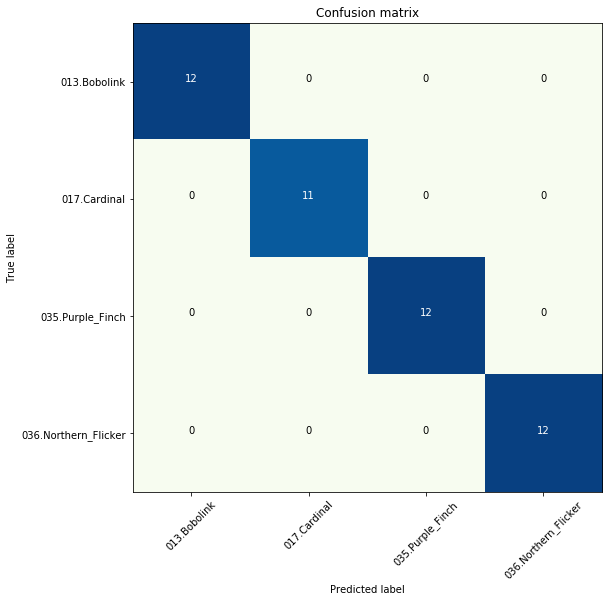

In [40]:
create_and_plot_confusion_matrix(acts, preds)

Testing 48 images
ERROR on image index 7 -- Pred: 035.Purple_Finch 0.35, Actual: 017.Cardinal
    [0.04884261265397072, 0.3346782922744751, 0.35209375619888306, 0.26438531279563904]


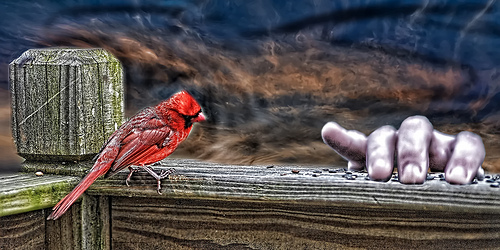


Accuracy: 0.98, 47/48
CPU times: user 1.06 s, sys: 3.85 ms, total: 1.06 s
Wall time: 7.96 s


In [41]:
%%time 
num_images = test_df.shape[0]
num_errors, preds, acts = test_image_df(test_df)
print('\nAccuracy: {:.2f}, {}/{}'.format(1 - (num_errors/num_images), num_images - num_errors, num_images))

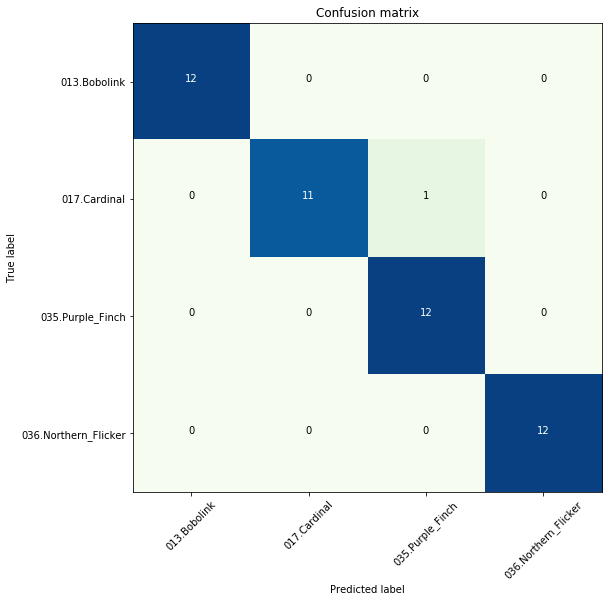

In [42]:
create_and_plot_confusion_matrix(acts, preds)

### Test model against previously unseen images
Here we download images that the algorithm has not yet seen.

...took 0.15 seconds


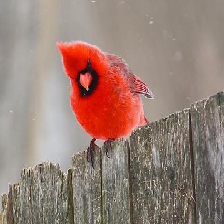

Class: 017.Cardinal, confidence: 0.97
...took 0.15 seconds


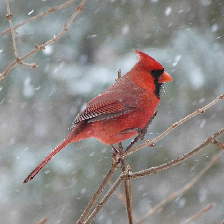

Class: 017.Cardinal, confidence: 0.89


[0.008297104388475418,
 0.8916934728622437,
 0.08866697549819946,
 0.011342387646436691]

In [43]:
predict_bird_from_file('northern-cardinal-2.jpg')
predict_bird_from_file('northern-cardinal-1.jpg')

## Clean up
Finally, and importantly, to avoid being billed for an idle endpoint, here we delete the SageMaker endpoint.

In [44]:
predictor.delete_endpoint()